In [4]:
# obtain homemade search engine
!wget https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

--2024-11-10 23:33:33--  https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3832 (3.7K) [text/plain]
Saving to: ‘minsearch.py.1’

minsearch.py.1      100%[===================>]   3.74K  --.-KB/s    in 0s      

2024-11-10 23:33:34 (45.1 MB/s) - ‘minsearch.py.1’ saved [3832/3832]



In [3]:
# import libraries
import minsearch
import json
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
from tqdm.auto import tqdm


## Ingestion

In [6]:
# load the cleaned up json file
with open('../data/cleaned_Data.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [7]:
# add the actual course (only one is ASU online) to the question-level info
documents = []

for id, doc in enumerate(docs_raw['documents']):
    doc['id'] = id #set up a unique id
    doc['course'] = docs_raw['course']
    documents.append(doc)

In [8]:
documents[10]

{'text': 'Textbook costs are not included in tuition.',
 'section': 'Common questions about ASU Online',
 'question': 'Are textbook costs included in tuition?',
 'id': 10,
 'course': 'ASU Online'}

In [9]:
# setup data indexing using minsearch
index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course","id"]
)

In [10]:
#actually index the data
index.fit(documents)

## RAG flow

In [11]:
# setup API key
load_dotenv('../.envrc') 
openai_api_key = os.getenv('OPENAI_API_KEY')

In [12]:
# start an openAI client
client = OpenAI()

In [13]:
# set up RAG definitions
def search(query,boost=None):
    '''
    This function retrieves the top 5 results from an indexed search enging.
    We are using a homemade engine called 'minsearch' which has been
    developed by alexey grigorev.
    '''
    if boost is None:
        boost = {'question': 3.0, 'section': 0.5}

    results = index.search(
        query = query,
        filter_dict={'course':'ASU Online'}, #this is a bit moo, but done for continuity
        boost_dict=boost,
        num_results=10
        )
    
    return results

def build_prompt(query,search_results):
    '''  
    This function creates an LLM friendly prompt using the results from a search engine
    as background information input.
    '''
    prompt_template = """ 
    You are a course teaching assistant. Please answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.

    QUESTION: {question}

    CONTEXT: {context}

    """.strip()

    context= ""

    # concatenate search results as one text string
    for doc in search_results:
        context = context + f'section: {doc['section']} \nquestion: {doc['question']} \nanswer: {doc['text']}\n\n'

    # fill out the prompt template
    prompt = prompt_template.format(question=query, context=context).strip()

    return prompt

def llm(prompt,model='gpt-4o-mini'):
    '''  
    This function contacts sets up the LLM model and runs the formatted prompt
    '''
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content
    


In [14]:
# set up the RAG using the 3 steps above
def rag(query,model='gpt-4o-mini',boost=None):
    ''' 
    This function generates a Retrieval-Augmented generation model architecture.
    It combines search engine retrieval results with LLM to give a user-friendly answer.
    '''
    search_results = search(query,boost=boost)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt,model=model)
    return answer

In [15]:
# try out a query
# test a search
query = 'what do I need to enroll to online graduate classes?'
answer = rag(query)

In [16]:
print(answer)

To enroll in online graduate classes at ASU Online, you need to apply to a graduate program, which you can do while in your final year of your undergraduate degree. You will need to provide your junior-senior GPA, which can be an estimate if you are still completing your degree. You may submit unofficial transcripts as part of your application but will need to send official transcripts if accepted. Additionally, you should keep in mind the application deadlines, which vary by program and usually require you to apply at least a month or two in advance of your chosen start date.

Once you are admitted, you can log in to My ASU with your ASURITE ID and password, use the 'Class Search' to find your classes, and follow the enrollment steps.


## Retrieval Evaluation
Set up functions for retrieval evaluation metrics, and apply to ground truth data.

In [17]:
# set up functions for evaluation metrics
def hit_rate(relevance_total):
    ''' 
    This fcn evaluates hit rate
    '''
    cnt = 0
    # count if any True found on line
    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    '''
    this fcn evaluates mean reciprocal rank
    '''
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)
                break

    return total_score / len(relevance_total)


In [18]:
def evaluate(ground_truth, search_function):
    ''' 
    This function uses any specific search engine you set up to 
    check out the ground truch, and it evaluates the 2 metrics 
    '''
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['id']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [19]:
#read in data
df_question = pd.read_csv('../data/ground_truth_data.csv')

# convert to dict
ground_truth = df_question.to_dict(orient='records')

ground_truth[0]

{'id': 0,
 'course': 'ASU Online',
 'question': 'Can I transfer ASU Online credits to other universities?'}

In [20]:
# evaluate how good the search engine is depending on boosting
evaluate(ground_truth, lambda q: search(q['question'],boost={}))

  0%|          | 0/265 [00:00<?, ?it/s]

{'hit_rate': 0.720754716981132, 'mrr': 0.4907666966157533}

### Finding the best parameters
Let us find the best parameters that maximize eval metrics

In [21]:
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
# if hyperopt not running do pip install --upgrade setuptools

In [22]:
# get some subset of data to validate against
df_validation = df_question[:100]
data_val = df_validation.to_dict(orient='records')

In [23]:
# Define the search space for the boosts
search_space = {
    'question_boost': hp.uniform('question_boost', 0.0, 5.0),  # Boost for 'question' between 1.0 and 5.0
    'section_boost': hp.uniform('section_boost', 0.0, 2.0)    # Boost for 'section' between 0.1 and 2.0
}

def objective(params):
    # Use the evaluate function to get hit rate and MRR for current boost values
    boost = {'question': params['question_boost'], 'section': params['section_boost']}
    
    # Call the evaluate function with the new boost values
    results = evaluate(data_val, lambda q: search(q['question'], boost=boost))
      
    # Combine hit rate and MRR for optimization
    combined_score = 0.5 * results['hit_rate'] + 0.5 * results['mrr']  # Adjust weights as needed
    
    return -combined_score


# Set up hyperopt search
trials = Trials()  # To store information about each trial

best_boost = fmin(
    fn=objective,           # Objective function to minimize
    space=search_space,      # The parameter space
    algo=tpe.suggest,        # Tree of Parzen Estimators algorithm
    max_evals=50,            # Number of trials
    trials=trials,           # To store the trials
    rstate=np.random.default_rng(42)  # Set a random seed for reproducibility
)

# Print the best boost values found by hyperopt
print("Best boost values:", best_boost)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:05,  8.38trial/s, best loss: -0.6381507936507937]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:00<00:04,  9.92trial/s, best loss: -0.8522916666666667]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 5/50 [00:00<00:04,  9.66trial/s, best loss: -0.8522916666666667]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:00<00:04, 10.34trial/s, best loss: -0.8522916666666667]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:00<00:04,  9.93trial/s, best loss: -0.8522916666666667]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [00:01<00:03, 10.35trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [00:01<00:03,  9.98trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 15/50 [00:01<00:03, 10.37trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 34%|███▍      | 17/50 [00:01<00:03, 10.08trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 38%|███▊      | 19/50 [00:01<00:02, 10.39trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 42%|████▏     | 21/50 [00:02<00:02, 10.01trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [00:02<00:02, 10.19trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 25/50 [00:02<00:02,  9.83trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 54%|█████▍    | 27/50 [00:02<00:02, 10.25trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 58%|█████▊    | 29/50 [00:02<00:01, 10.59trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 62%|██████▏   | 31/50 [00:03<00:01, 10.27trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [00:03<00:01,  9.85trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 70%|███████   | 35/50 [00:03<00:01, 10.23trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 74%|███████▍  | 37/50 [00:03<00:01, 10.12trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 78%|███████▊  | 39/50 [00:03<00:01, 10.35trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 82%|████████▏ | 41/50 [00:04<00:00, 10.09trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [00:04<00:00, 10.57trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 90%|█████████ | 45/50 [00:04<00:00,  9.87trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [00:04<00:00, 10.12trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [00:04<00:00, 10.00trial/s, best loss: -0.8855833333333333]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 10.14trial/s, best loss: -0.8855833333333333]
Best boost values: {'question_boost': np.float64(0.20630178685456357), 'section_boost': np.float64(0.0694068717136398)}


In [24]:
# check final evaluation using optimized values
evaluate(ground_truth, lambda q: search(q['question'],boost={'question': 0.2, 'section': 0.07}))


  0%|          | 0/265 [00:00<?, ?it/s]

{'hit_rate': 0.9433962264150944, 'mrr': 0.7738349805330936}

## RAG evaluation
We are going to use the cosine similarity metric to evaluate the quality of our RAG flow.

In [10]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
transform_model = SentenceTransformer(model_name)

In [26]:
def process_record(rec,model='gpt-4o-mini'):
    '''
    This fcn processes the question on the record, obtains a RAG answer, and stores the 
    LLM answer, the actual answer, and other metadata per question.
    '''
    boost={'question': 0.2, 'section': 0.07}

    query = rec['question']
    answer_llm = rag(query,model=model,boost=boost)
    
    doc_id = rec['id']
    original_doc = documents[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': query,
        'course': rec['course'],
    }

In [8]:
def compute_similarity(record):
    ''' 
    This function calculates the cosine similarity metric for RAG evaluation.
    It uses a sentence transformer from huggingface to convert sentences to vectors.
    Then the vector similarity is calculated via cosines.
    '''
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = transform_model.encode(answer_llm)
    v_orig = transform_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [28]:
# test process record fcn
rec = ground_truth[10]
out = process_record(rec,model='gpt-4o-mini')
out

{'answer_llm': 'To complete the ASU Online admission process, you will need to submit an undergraduate application, pay the application fee, and ensure that ASU receives all required transcripts. If you have not completed an associate degree, you will also need to have your official high school transcripts sent to ASU. The transcripts should be sent to: \n\nAdmission Services  \nArizona State University  \nPO Box 870112  \nTempe, AZ 85287-0112',
 'answer_orig': "Your application is complete once you pay the application fee and ASU receives all of your required transcripts. If you haven't completed an associate degree, you'll need to have your official high school transcripts sent to us. Please have you transcripts sent to:Admission ServicesArizona State UniversityPO Box 870112Tempe, AZ 85287-0112",
 'document': 2,
 'question': 'What materials are necessary to complete the ASU Online admission process?',
 'course': 'ASU Online'}

### GPT-4o-mini

In [29]:
# process all records using fcn
results_gpt4omini = []
for record in tqdm(ground_truth):
    result = process_record(record,model='gpt-4o-mini')
    results_gpt4omini.append(result)

  0%|          | 0/265 [00:00<?, ?it/s]

In [30]:
# save processed records
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('../data/results-gpt4o-mini.csv', index=False)


In [6]:

# load processed records
df_gpt4o_mini = pd.read_csv('../data/results-gpt4o-mini.csv')
results_gpt4omini = df_gpt4o_mini.to_dict(orient='records')


In [11]:
# calculate cosine similarity for gpt 4o mini
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/265 [00:00<?, ?it/s]

In [12]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    265.000000
mean       0.796803
std        0.129259
min        0.383902
25%        0.704370
50%        0.829031
75%        0.890507
max        1.000000
Name: cosine, dtype: float64

### GPT-4o

In [33]:
results_gpt4o = []

In [34]:
processed_questions = {record['question'] for record in results_gpt4o}

In [35]:
# process all records using fcn
for record in tqdm(ground_truth):
    if record['question'] in processed_questions:
        continue
    else:
        result = process_record(record,model='gpt-4o')
        results_gpt4o.append(result)

  0%|          | 0/265 [00:00<?, ?it/s]

In [36]:
# save processed records
df_gpt4o = pd.DataFrame(results_gpt4o)
df_gpt4o.to_csv('../data/results-gpt4o.csv', index=False)

In [13]:

# load processed records
df_gpt4o = pd.read_csv('../data/results-gpt4o.csv')
results_gpt4o = df_gpt4o.to_dict(orient='records')


In [14]:
# calculate cosine similarity for gpt 4o mini
similarity_4o = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity_4o.append(sim)

  0%|          | 0/265 [00:00<?, ?it/s]

In [15]:
df_gpt4o['cosine'] = similarity_4o
df_gpt4o['cosine'].describe()

count    265.000000
mean       0.795121
std        0.131784
min        0.427088
25%        0.714674
50%        0.820756
75%        0.896298
max        0.992213
Name: cosine, dtype: float64

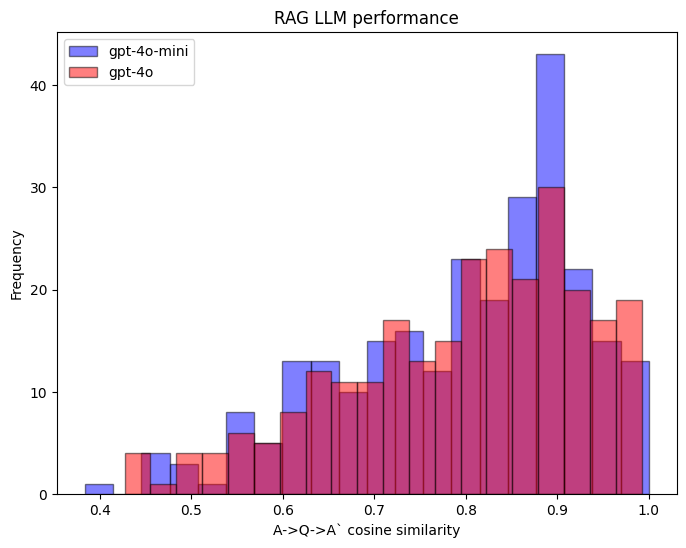

In [16]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.hist(df_gpt4o_mini['cosine'], bins=20, alpha=0.5,label='gpt-4o-mini',color='blue', edgecolor='black')
plt.hist(df_gpt4o['cosine'], bins=20, alpha=0.5,label='gpt-4o',color='red', edgecolor='black')

# Adding labels and title
plt.xlabel('A->Q->A` cosine similarity')
plt.ylabel('Frequency')
plt.title('RAG LLM performance')

# Show the plot
plt.legend()
plt.savefig('../data/cosine-similarity-image.png', dpi=300, bbox_inches='tight')
plt.show()


In [40]:
df_temp = df_gpt4o[df_gpt4o['cosine'] <=0.5]
df_temp.to_csv('../data/results-badCosine-gpt4o.csv', index=False)

df_temp = df_gpt4o_mini[df_gpt4o_mini['cosine'] <=0.5]
df_temp.to_csv('../data/results-badCosine-gpt4o-mini.csv', index=False)

### NOTE
After analyzing the data to see which ones were not performing well, we found out that the last question did not have the correct answer on the feeding ground data. We corrected and rerun everything to keep continuity. Now everything seems good.

In [42]:
df_temp

,answer_llm,answer_orig,document,question,course,cosine
60,"To apply to a graduate program at ASU Online, ...",We don't consider graduate students as transfe...,12,What is the process for applying to a graduate...,ASU Online,0.472286
214,The provided context does not specify if there...,"Typically, Arizona State University credits do...",42,Is there a time limit for using my ASU credits?,ASU Online,0.470815
232,"Yes, unofficial transcripts are acceptable whe...","No, you can apply to a graduate program while ...",46,Are unofficial transcripts acceptable when app...,ASU Online,0.450422
235,ASU does not specifically mention live teachin...,Arizona State University offers most of its on...,47,Does ASU offer live teaching sessions for onli...,ASU Online,0.492270
238,To find out about specific course requirements...,Arizona State University offers most of its on...,47,How can I find out about specific course requi...,ASU Online,0.486248
248,"Yes, there are options for transferring credit...",That depends on your specific situation and ho...,49,Are there options for transferring credits tha...,ASU Online,0.447867
249,To get a personalized estimate on your degree ...,That depends on your specific situation and ho...,49,Who can I speak to for a personalized estimate...,ASU Online,0.383902
